# Retention Study - Figuring Out Which Employees May Quit

### Data Source
- https://www.kaggle.com/arvindbhatt/hrcsv

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
from matplotlib.legend_handler import HandlerLine2D
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Reading data 

In [ ]:
def read_data_file(path):
  return pd.read_csv(path)

In [ ]:
# file path
file_name = "hr_data.csv"
data = read_data_file(file_name)
data.head()

,employee_id,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary
0,1003,2,157,3,0,1,0,sales,low
1,1005,5,262,6,0,1,0,sales,medium
2,1486,7,272,4,0,1,0,sales,medium
3,1038,5,223,5,0,1,0,sales,low
4,1057,2,159,3,0,1,0,sales,low


In [ ]:
file_name = "employee_satisfaction_evaluation.xlsx"
emp_satis_eval = pd.read_excel(file_name)

emp_satis_eval.head()

,EMPLOYEE #,satisfaction_level,last_evaluation
0,1003,0.38,0.53
1,1005,0.80,0.86
2,1486,0.11,0.88
3,1038,0.72,0.87
4,1057,0.37,0.52


> There is common column employee id.
- EMPLOYEE #(Employee statisfaction data) is sames as employee id from data set. SO we can merge both data set on the basis of common employee id column 

In [ ]:
data = data.set_index('employee_id').join(emp_satis_eval.set_index('EMPLOYEE #'))
data = data.reset_index()
data.head(1)

,employee_id,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary,satisfaction_level,last_evaluation
0,1003,2,157,3,0,1,0,sales,low,0.38,0.53


### Basic Exploration

In [ ]:
# Print first 10 data points
data.head(10)

,employee_id,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary,satisfaction_level,last_evaluation
0,1003,2,157,3,0,1,0,sales,low,0.38,0.53
1,1005,5,262,6,0,1,0,sales,medium,0.80,0.86
2,1486,7,272,4,0,1,0,sales,medium,0.11,0.88
3,1038,5,223,5,0,1,0,sales,low,0.72,0.87
4,1057,2,159,3,0,1,0,sales,low,0.37,0.52
5,1060,2,153,3,0,1,0,sales,low,0.41,0.50
6,1061,6,247,4,0,1,0,sales,low,0.10,0.77
7,1576,5,259,5,0,1,0,sales,low,0.92,0.85
8,1752,5,224,5,0,1,0,sales,low,0.89,1.00
9,1988,2,142,3,0,1,0,sales,low,0.42,0.53


In [ ]:
# Info abount data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   employee_id            14999 non-null  int64  
 1   number_project         14999 non-null  int64  
 2   average_montly_hours   14999 non-null  int64  
 3   time_spend_company     14999 non-null  int64  
 4   Work_accident          14999 non-null  int64  
 5   left                   14999 non-null  int64  
 6   promotion_last_5years  14999 non-null  int64  
 7   department             14999 non-null  object 
 8   salary                 14999 non-null  object 
 9   satisfaction_level     14972 non-null  float64
 10  last_evaluation        14972 non-null  float64
dtypes: float64(2), int64(7), object(2)
memory usage: 1.3+ MB


#### Observation
- There are total 14999 data points
- There are total 9 columns out of which one column for target
- All columns are int64 except department and salary.
- Department and salary are categorical columns

In [ ]:
# Column Names
print('data set contain columns')
print(data.columns)

data set contain columns
Index(['employee_id', 'number_project', 'average_montly_hours',
       'time_spend_company', 'Work_accident', 'left', 'promotion_last_5years',
       'department', 'salary', 'satisfaction_level', 'last_evaluation'],
      dtype='object')


In [ ]:
# print shape of data
data.shape

(14999, 11)

### Basic Statistics

In [ ]:
# Check null value of data
data.isnull().sum()

employee_id               0
number_project            0
average_montly_hours      0
time_spend_company        0
Work_accident             0
left                      0
promotion_last_5years     0
department                0
salary                    0
satisfaction_level       27
last_evaluation          27
dtype: int64

> There are two columns satisfaction_level and last_evaluation_level having 27 value as null

In [ ]:
# Check duplicate data 
# Duplicated data based on employee_id
duplicate = data[data['employee_id'].duplicated()]
print('There are {} duplicate data based on employee id'.format(len(duplicate)))

There are 0 duplicate data based on employee id


### Fill Missing value

In [ ]:
# Show the missing value data points
data[data['satisfaction_level'].isnull()]

,employee_id,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary,satisfaction_level,last_evaluation
18,3794,2,160,3,1,1,1,sales,low,NaN,NaN
19,1140,5,262,5,0,1,0,sales,low,NaN,0.89
33,1230,2,140,3,0,1,0,hr,low,NaN,NaN
53,1340,2,132,3,0,1,0,support,low,NaN,NaN
72,22316,2,149,3,0,1,0,product_mng,high,NaN,NaN
92,1581,2,143,3,0,1,0,sales,low,NaN,NaN
107,17376,2,148,3,0,1,0,accounting,medium,NaN,NaN
120,1739,4,158,4,1,1,0,technical,low,NaN,NaN
137,1847,2,129,3,0,1,0,management,low,NaN,NaN
175,32923,4,164,2,0,1,0,sales,low,NaN,NaN


In [ ]:
data.columns

Index(['employee_id', 'number_project', 'average_montly_hours',
       'time_spend_company', 'Work_accident', 'left', 'promotion_last_5years',
       'department', 'salary', 'satisfaction_level', 'last_evaluation'],
      dtype='object')

In [ ]:
# Fill Missing values using Average value of the column
data['satisfaction_level'].fillna(data['satisfaction_level'].mean(), inplace=True)
data['last_evaluation'].fillna(data['last_evaluation'].mean(), inplace=True)

In [ ]:
data.isnull().sum()

employee_id              0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
satisfaction_level       0
last_evaluation          0
dtype: int64

### Exploratory Data Analysis

##### Analysis of department

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


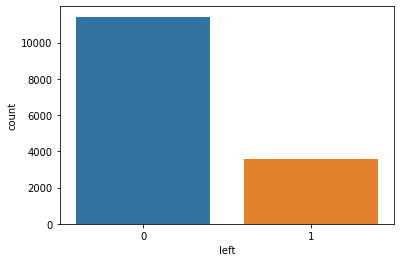

In [ ]:
# Target distributation
sns.countplot(data['left'])

In [ ]:
data['left'].value_counts()

0    11428
1     3571
Name: left, dtype: int64

<Figure size 720x720 with 0 Axes>

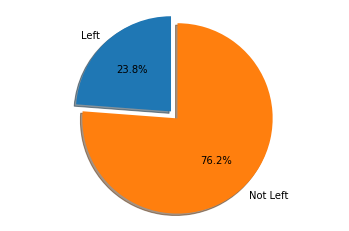

In [ ]:
# Plot Pi chart
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
plt.figure(figsize=(10,10))
labels = 'Left', 'Not Left'
sizes = [3571, 11428]
explode = (0.1, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


- The data points are imbalanced.
- 76.2% of the data points belongs to not left employee
- 23.8% of the data points belongs to left employee

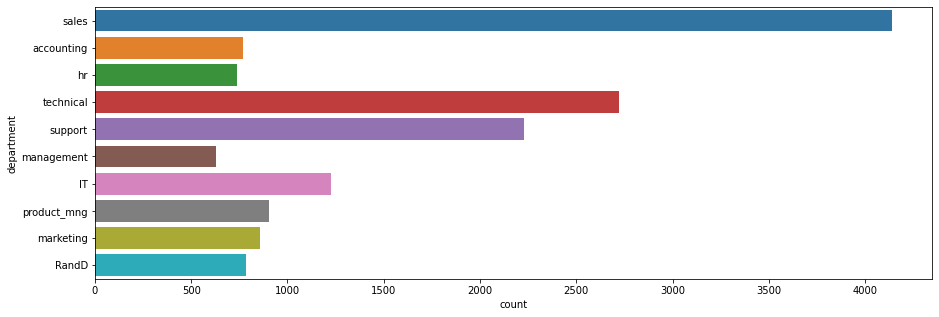

In [ ]:
plt.figure(figsize=(15,5))
sns.countplot(y='department',data=data, orient='h')

- There are more number of employee belongs to sales
- There are less number of employee belongs to management

In [ ]:
data['department'].value_counts()

sales          4140
technical      2720
support        2229
IT             1227
product_mng     902
marketing       858
RandD           787
accounting      767
hr              739
management      630
Name: department, dtype: int64

<Figure size 720x720 with 0 Axes>

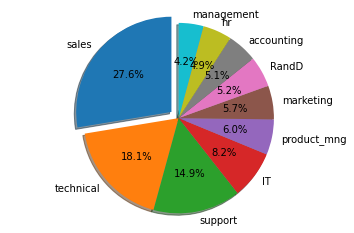

In [ ]:
# Plot Pi chart
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
plt.figure(figsize=(10,10))
labels = 'sales', 'technical', 'support', 'IT','product_mng','marketing','RandD','accounting','hr','management'
sizes = [4140, 2720, 2229, 1227,902,858,787,767,739,630]
explode = (0.1, 0, 0, 0,0,0,0,0,0,0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


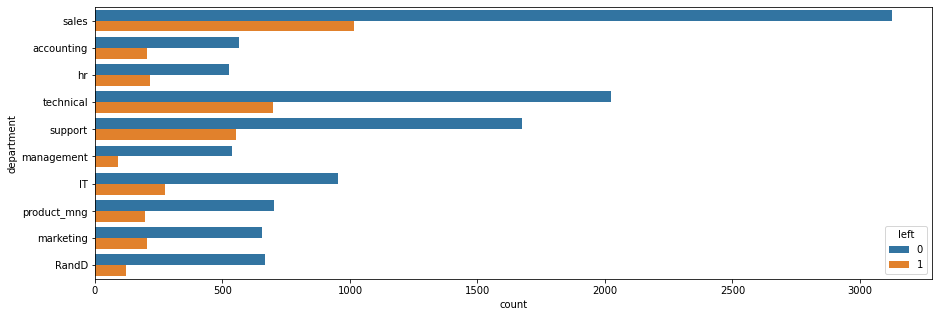

In [ ]:
# Show the bar plot according to employee left
plt.figure(figsize=(15,5))
sns.countplot(y='department',data=data,hue='left')

In [ ]:
# print the percentage of people left from department
def get_percent_employee_by_department(value_counts,column_name, df):
  index_list = value_counts.index
  percentage_dict = dict()
  for item in index_list:
    data = value_counts[item]
    # Total data for single department
    total = len(df[(df[column_name] == item) & (df['left'] == 1)].index)
    fraction = round(total/data,2)
    percentage = fraction*100
    percentage_dict[item] = percentage
  return percentage_dict


In [ ]:
get_percent_employee_by_department(data['department'].value_counts(),'department',data)

{'IT': 22.0,
 'RandD': 15.0,
 'accounting': 27.0,
 'hr': 28.999999999999996,
 'management': 14.000000000000002,
 'marketing': 24.0,
 'product_mng': 22.0,
 'sales': 24.0,
 'support': 25.0,
 'technical': 26.0}

- It seems that employee from hr department left more.
- less number of employee left from management

##### Analysis of number_project

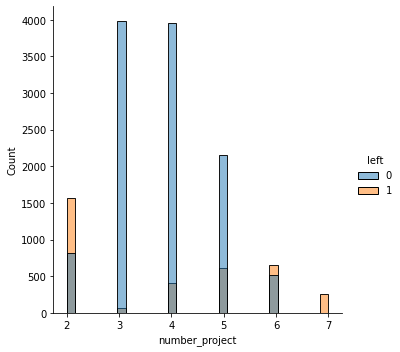

In [ ]:
sns.displot(data,x='number_project', hue='left')

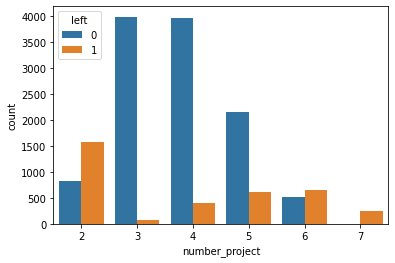

In [ ]:
sns.countplot(x='number_project',data=data,hue='left')

- There are More number of employee allocate to 3 or 4 projects
- The more number of employee left who are allocated to projects 2
- All employee allocate to 7 projects left the company

> Number of projects is a categorical variable

##### Analysis of average_montly_hours

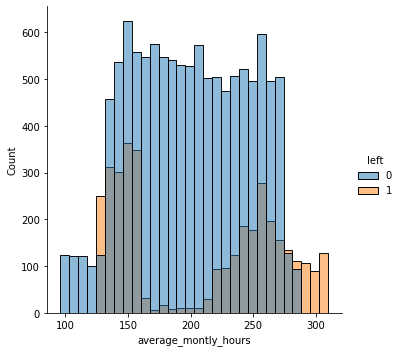

In [ ]:
# sns.distplot(data,x='average_montly_hours',hue='left')
sns.displot(data=data, x="average_montly_hours", hue="left")

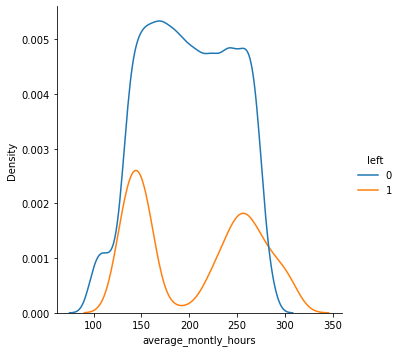

In [ ]:
sns.displot(data=data, x="average_montly_hours", hue="left",kind="kde")

> Distribution of average_montly_hours for the employee who left is biomodal. The employee who left has uniform distributation.
- The employee who left are more skew than the employee who not left the employee
- we can some how differentiation between the employee who left or not

##### Analysis of time_spend_company

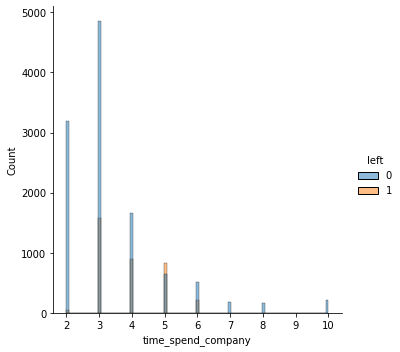

In [ ]:
sns.displot(data=data, x="time_spend_company", hue="left")

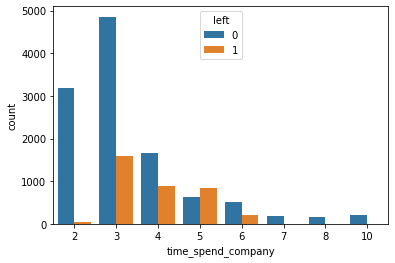

In [ ]:
sns.countplot(x='time_spend_company',data=data,hue='left')

- The employees who spend in the company 2 years not intended to leave the company
- The employee who have spend more than 7 do not ointend to leave the company
- More number of employee who spend times 3,4, or 5 years tend to left the employee
- we can distinguish the employee on the basis of time spend

In [ ]:
data.columns

Index(['employee_id', 'number_project', 'average_montly_hours',
       'time_spend_company', 'Work_accident', 'left', 'promotion_last_5years',
       'department', 'salary', 'satisfaction_level', 'last_evaluation'],
      dtype='object')

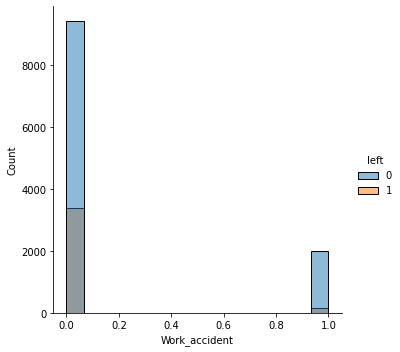

In [ ]:
sns.displot(data=data, x="Work_accident", hue="left")

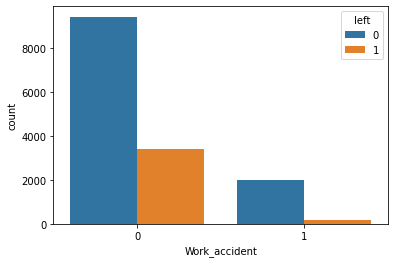

In [ ]:
sns.countplot(x='Work_accident',data=data,hue='left')

The more number of employee who met with work accident left the company

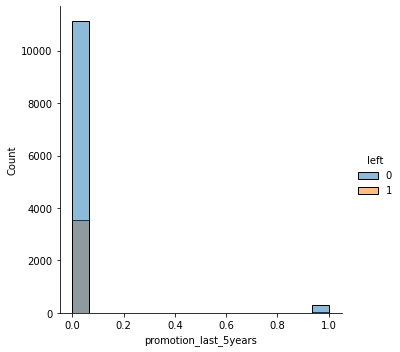

In [ ]:
sns.displot(data=data, x="promotion_last_5years", hue="left")

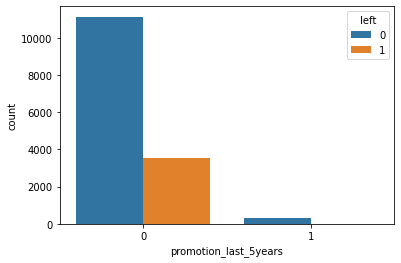

In [ ]:
sns.countplot(x='promotion_last_5years',data=data,hue='left')

The employee who did not get permotion tend to left the company

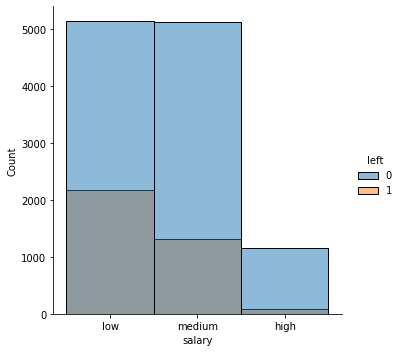

In [ ]:
sns.displot(data=data, x="salary", hue="left")

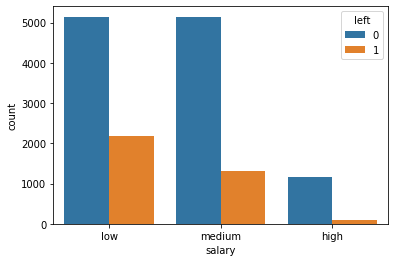

In [ ]:
sns.countplot(x='salary',data=data,hue='left')

- The employee have low and medium salary tend to left the company
- The employee have high salary less tend to left the company 

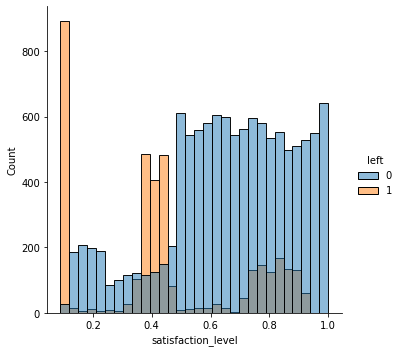

In [ ]:
sns.displot(data=data, x="satisfaction_level", hue="left")

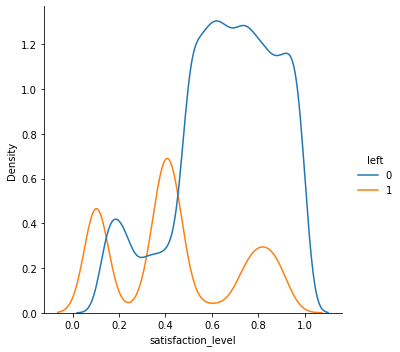

In [ ]:
sns.displot(data=data, x="satisfaction_level", hue="left",kind="kde")

We can make differentiate the employee on the basis of staisfaction level

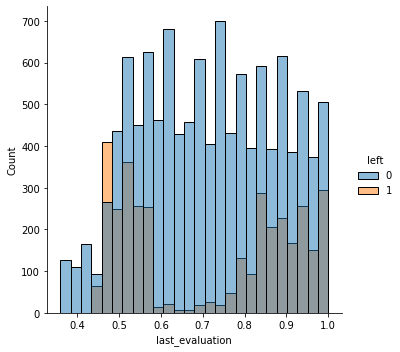

In [ ]:
sns.displot(data=data, x="last_evaluation", hue="left")

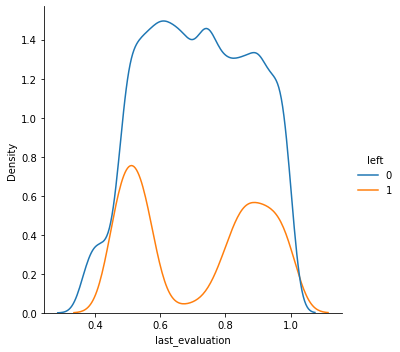

In [ ]:
sns.displot(data=data, x="last_evaluation", hue="left",kind="kde")

- There are bimodal distributation of the employee who left the company.
- The distributation of the employee who not left the employee have uniform distributation
- We can differentiate the employee on the basis of last_evaluation

### Featurizing Data set

In [ ]:
data.head(3)

,employee_id,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary,satisfaction_level,last_evaluation
0,1003,2,157,3,0,1,0,sales,low,0.38,0.53
1,1005,5,262,6,0,1,0,sales,medium,0.80,0.86
2,1486,7,272,4,0,1,0,sales,medium,0.11,0.88


In [ ]:
# Create avg number of hours spend per project
data['avg_hrs_per_project'] = data['average_montly_hours']/data['number_project']
# Ratio of Project to time spend in company
data['ratio_project_timespend'] = data['number_project']/data['time_spend_company']


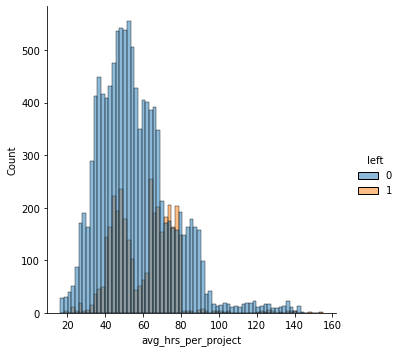

In [ ]:
# Analysis of avg_hrs_per_project
sns.displot(data=data, x="avg_hrs_per_project", hue="left")

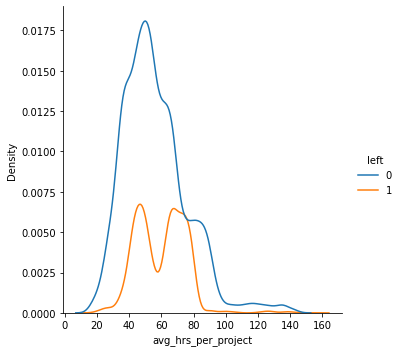

In [ ]:
sns.displot(data=data, x="avg_hrs_per_project", hue="left",kind="kde")

### Build Machine Learning Model

In [ ]:
categorical_column = ['department','salary']
main_df_final = pd.get_dummies(data, columns=categorical_column, drop_first=True)
main_df_final.head()

,employee_id,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,satisfaction_level,last_evaluation,avg_hrs_per_project,ratio_project_timespend,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_low,salary_medium
0,1003,2,157,3,0,1,0,0.38,0.53,78.500000,0.666667,0,0,0,0,0,0,1,0,0,1,0
1,1005,5,262,6,0,1,0,0.80,0.86,52.400000,0.833333,0,0,0,0,0,0,1,0,0,0,1
2,1486,7,272,4,0,1,0,0.11,0.88,38.857143,1.750000,0,0,0,0,0,0,1,0,0,0,1
3,1038,5,223,5,0,1,0,0.72,0.87,44.600000,1.000000,0,0,0,0,0,0,1,0,0,1,0
4,1057,2,159,3,0,1,0,0.37,0.52,79.500000,0.666667,0,0,0,0,0,0,1,0,0,1,0


In [ ]:
# drop employee_id from main data frame
main_df_final.drop(['employee_id'],inplace=True,axis=1)
main_df_final.head(2)

,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,satisfaction_level,last_evaluation,avg_hrs_per_project,ratio_project_timespend,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_low,salary_medium
0,2,157,3,0,1,0,0.38,0.53,78.5,0.666667,0,0,0,0,0,0,1,0,0,1,0
1,5,262,6,0,1,0,0.80,0.86,52.4,0.833333,0,0,0,0,0,0,1,0,0,0,1


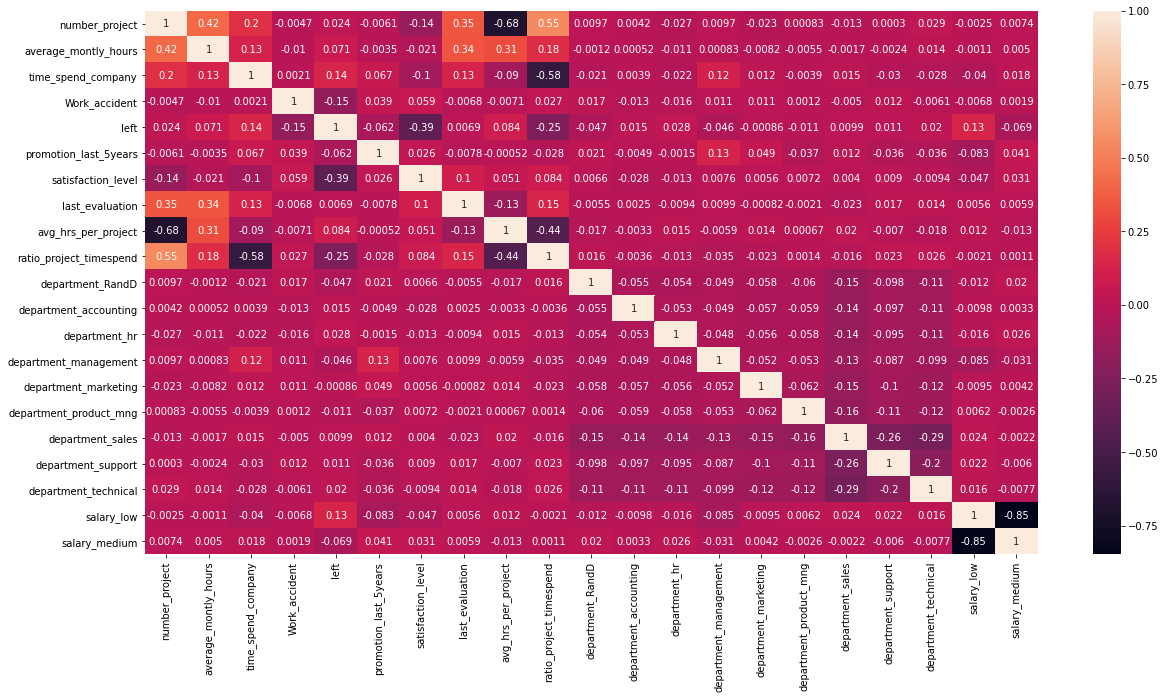

In [ ]:
# Check the correlation between variables
def plot_corr(df,size=10):
    plt.figure(figsize=(20,10))
    sns.heatmap(df.corr(), annot = True)
    
plot_corr(main_df_final)

In [ ]:
# Train test split of data points 
from sklearn.model_selection import train_test_split

In [ ]:
X = main_df_final.drop(['left'],axis=1)
y = main_df_final['left']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33,stratify=y)

In [ ]:
# Train and test data shape
print('Train data set shape')
print(X_train.shape)
print('Test data set shape')
print(X_test.shape)

Train data set shape
(10049, 20)
Test data set shape
(4950, 20)


In [ ]:
y_train.value_counts()

0    7657
1    2392
Name: left, dtype: int64

<Figure size 720x720 with 0 Axes>

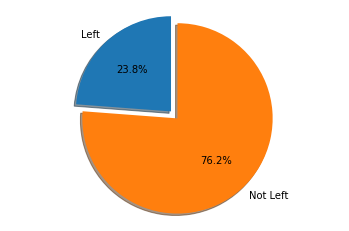

In [ ]:
# Distributation of target in train and test data set
# Plot Pi chart
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
plt.figure(figsize=(10,10))
labels = 'Left', 'Not Left'
sizes = [2392, 7657]
explode = (0.1, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


In [ ]:
y_test.value_counts()

0    3771
1    1179
Name: left, dtype: int64

<Figure size 720x720 with 0 Axes>

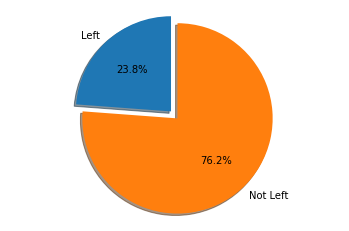

In [ ]:
# Distributation of target in train and test data set
# Plot Pi chart
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
plt.figure(figsize=(10,10))
labels = 'Left', 'Not Left'
sizes = [1179, 3771]
explode = (0.1, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


In [ ]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [ ]:
# PLot the AUC curve for predicted data
def plotAUC(train_false_postive_rate,train_true_postive_rate,test_false_postive_rate,test_true_postive_rate):
    plt.plot(train_false_postive_rate, train_true_postive_rate, label="train AUC ="+str(auc(train_false_postive_rate, 
                                                                                        train_true_postive_rate)))
    plt.plot(test_false_postive_rate, test_true_postive_rate, label="test AUC ="+str(auc(test_false_postive_rate, 
                                                                                     test_true_postive_rate)))
    plt.legend()
    plt.xlabel("Lambda")
    plt.ylabel("AUC")
    plt.title("ERROR PLOTS")
    plt.grid()
    plt.show()

In [ ]:
def plot_AUC_with_hyper_parameter(lambda_,train_result,test_result,hyper_parameter_name,is_log=False):
    plt.figure(figsize=(20,10))
    lambda_param = []
    if is_log:
        for param in lambda_:
            lambda_param.append(np.log10(param))
    else:
        lambda_param = lambda_
    line1, = plt.plot(lambda_param, train_result, 'b', label="Train AUC")
    line2, = plt.plot(lambda_param, test_result, 'r', label="Test AUC")

    plt.scatter(lambda_param, train_result, label='Train AUC points')
    plt.scatter(lambda_param, test_result, label='CV AUC points')
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel("Area under ROC curve")
    plt.xlabel("Hyper Parameter "+ hyper_parameter_name)
    plt.show()

In [ ]:
def grid_search(clf,train_data,y_train,cv,params):
  search_cv = GridSearchCV(clf,param_grid=params,n_jobs=-1,cv=cv,
                           scoring='roc_auc',
                           return_train_score=True,verbose=10)
  search_cv.fit(train_data,y_train)
  return search_cv

##### Logistic Regression with hyperparameter tuning

In [ ]:
# https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
def logistic_regression(train,y_train,test,y_test):
  standard_scallar = StandardScaler()
  train = standard_scallar.fit_transform(train)
  test = standard_scallar.transform(test)
  # Hyper parameter
  solver = ['newton-cg', 'lbfgs', 'liblinear']
  penalty = ['l2']
  c_values = [10 ** x for x in range(-5, 2)]
  param_grid = dict(solver=solver,penalty=penalty,C=c_values)
  # class8ifier
  clf = LogisticRegression(class_weight='balanced')
  cv = StratifiedKFold(n_splits=5,random_state=42,shuffle=True)
  search_cv = grid_search(clf,train_data=train,y_train=y_train,cv=cv,params=param_grid)
  best_params = search_cv.best_params_
  print('='*50)
  print('Best Paam')
  print(best_params)
  c_value = best_params['C']
  solver = best_params['solver']
  penalty = best_params['penalty']

  # FInal CLF
  clf = LogisticRegression(solver=solver,penalty=penalty,C=c_value,class_weight='balanced')
  clf.fit(train,y_train)
  # tRAING pREDICTION
  print('Training Data Results')
  predicted = clf.predict(train)
  print("Accuracy {0:.2f}%".format(100*accuracy_score(predicted, y_train)))
  print('Confusion matrix, Pecision, recall')
  plot_confusion_matrix(y_train, predicted)
  # Test Data results
  print('Test Data Results')
  predicted = clf.predict(test)
  print("Accuracy {0:.2f}%".format(100*accuracy_score(predicted, y_test)))
  print('Confusion matrix, Pecision, recall')
  plot_confusion_matrix(y_test, predicted)


Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1776s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1663s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:    5.1s finished


Best Paam
{'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
Training Data Results
Accuracy 82.65%
Confusion matrix, Pecision, recall


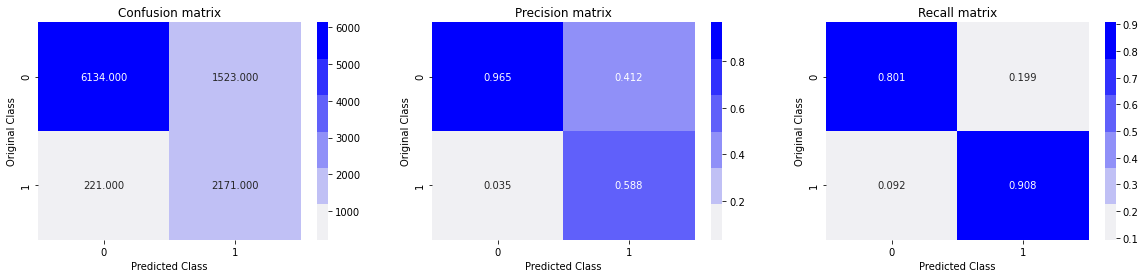

Test Data Results
Accuracy 82.59%
Confusion matrix, Pecision, recall


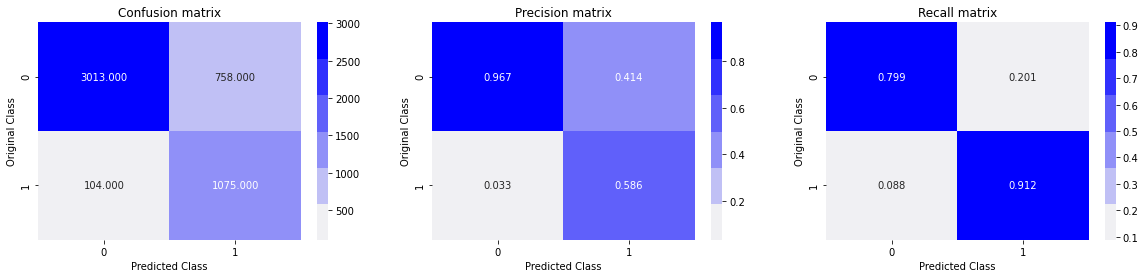

In [ ]:
logistic_regression(X_train,y_train,X_test,y_test)

### K-Nearest Neighbors (KNN)

In [ ]:
# https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
def Knn(train,y_train,test,y_test):
  standard_scallar = StandardScaler()
  train = standard_scallar.fit_transform(train)
  test = standard_scallar.transform(test)
  # Hyper parameter
  n_neighbors = range(1, 41, 2)
  weights = ['uniform', 'distance']
  metric = ['euclidean', 'manhattan', 'minkowski']
  param_grid = dict(n_neighbors=n_neighbors,weights=weights,metric=metric)
  # class8ifier
  clf = KNeighborsClassifier()
  cv = StratifiedKFold(n_splits=5,random_state=42,shuffle=True)
  search_cv = grid_search(clf,train_data=train,y_train=y_train,cv=cv,params=param_grid)
  best_params = search_cv.best_params_
  print('='*50)
  print('Best Paam')
  print(best_params)
  n_neighbors = best_params['n_neighbors']
  weights = best_params['weights']
  metric = best_params['metric']

  # FInal CLF
  clf = KNeighborsClassifier(n_neighbors=n_neighbors,weights=weights,metric=metric)
  clf.fit(train,y_train)
  # tRAING pREDICTION
  print('Training Data Results')
  predicted = clf.predict(train)
  print("Accuracy {0:.2f}%".format(100*accuracy_score(predicted, y_train)))
  print('Confusion matrix, Pecision, recall')
  plot_confusion_matrix(y_train, predicted)
  # Test Data results
  print('Test Data Results')
  predicted = clf.predict(test)
  print("Accuracy {0:.2f}%".format(100*accuracy_score(predicted, y_test)))
  print('Confusion matrix, Pecision, recall')
  plot_confusion_matrix(y_test, predicted)


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  5

Best Paam
{'metric': 'manhattan', 'n_neighbors': 35, 'weights': 'distance'}
Training Data Results
Accuracy 100.00%
Confusion matrix, Pecision, recall


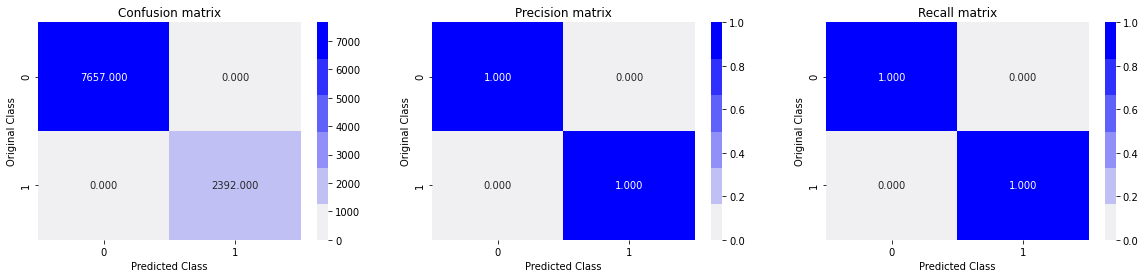

Test Data Results
Accuracy 96.12%
Confusion matrix, Pecision, recall


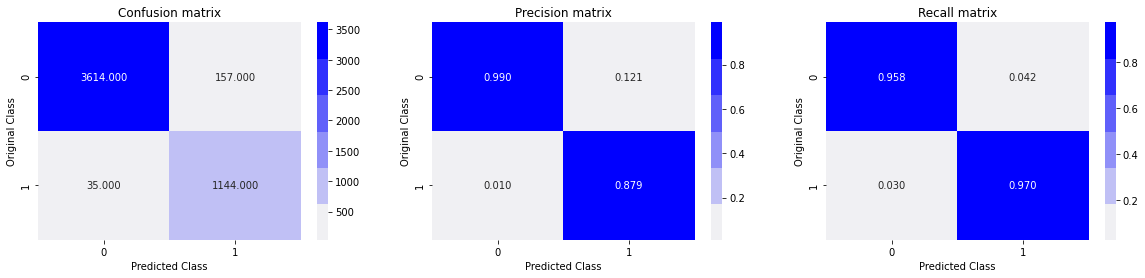

In [ ]:
Knn(X_train,y_train,X_test,y_test)


### Support Vector Machine (SVM)

In [ ]:
from sklearn.svm import SVC
def support_vec_machine(train,y_train,test,y_test):
  standard_scallar = StandardScaler()
  train = standard_scallar.fit_transform(train)
  test = standard_scallar.transform(test)
  # Hyper parameter
  c_values = [10 ** x for x in range(-2, 2)]
  # kernel = ['linear', 'poly', 'rbf', 'sigmoid']
  gamma = [1,0.1,0.01,0.001]
  param_grid = dict(C=c_values,gamma=gamma)
  # class8ifier
  clf = SVC()
  cv = StratifiedKFold(n_splits=5,random_state=42,shuffle=True)
  search_cv = grid_search(clf,train_data=train,y_train=y_train,cv=cv,params=param_grid)
  best_params = search_cv.best_params_
  print('='*50)
  print('Best Paam')
  print(best_params)
  c_values = best_params['C']
  # kernels = best_params['kernels']
  gamma = best_params['gamma']

  # FInal CLF
  clf = SVC(C=c_values,gamma=gamma)
  clf.fit(train,y_train)
  # tRAING pREDICTION
  print('Training Data Results')
  predicted = clf.predict(train)
  print("Accuracy {0:.2f}%".format(100*accuracy_score(predicted, y_train)))
  print('Confusion matrix, Pecision, recall')
  plot_confusion_matrix(y_train, predicted)
  # Test Data results
  print('Test Data Results')
  predicted = clf.predict(test)
  print("Accuracy {0:.2f}%".format(100*accuracy_score(predicted, y_test)))
  print('Confusion matrix, Pecision, recall')
  plot_confusion_matrix(y_test, predicted)


Training Data Results
Accuracy 99.07%
Confusion matrix, Pecision, recall


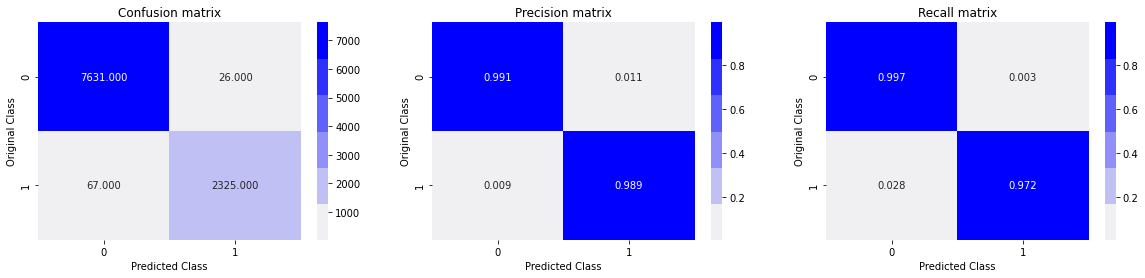

Test Data Results
Accuracy 97.64%
Confusion matrix, Pecision, recall


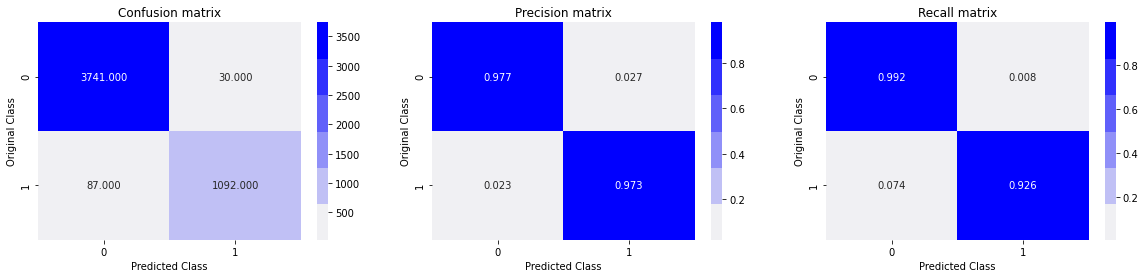

In [ ]:
support_vec_machine(X_train,y_train,X_test,y_test)


### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# https://towardsdatascience.com/optimizing-hyperparameters-in-random-forest-classification-ec7741f9d3f6
def random_forest_classifier(train,y_train,test,y_test):
  standard_scallar = StandardScaler()
  train = standard_scallar.fit_transform(train)
  test = standard_scallar.transform(test)
  # Hyper parameter
  n_estimators = [100, 300, 500, 800, 1200]
  max_depth = [5, 8,13, 15, 29, 21,25,27,29]
  # min_samples_split = [2, 5, 10, 15,20,30,50,75, 100]
  # min_samples_leaf = [1, 2, 5,7, 10,13] 
  param_grid = dict(n_estimators=n_estimators,max_depth=max_depth)
  # class8ifier
  clf = RandomForestClassifier()
  cv = StratifiedKFold(n_splits=5,random_state=42,shuffle=True)
  search_cv = grid_search(clf,train_data=train,y_train=y_train,cv=cv,params=param_grid)
  best_params = search_cv.best_params_
  print('='*50)
  print('Best Paam')
  print(best_params)
  n_estimators = best_params['n_estimators']
  max_depth = best_params['max_depth']
  # min_samples_split = best_params['min_samples_split']
  # min_samples_leaf = best_params['min_samples_leaf']

  # FInal CLF
  clf = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth)
  clf.fit(train,y_train)
  # tRAING pREDICTION
  print('Training Data Results')
  predicted = clf.predict(train)
  print("Accuracy {0:.2f}%".format(100*accuracy_score(predicted, y_train)))
  print('Confusion matrix, Pecision, recall')
  plot_confusion_matrix(y_train, predicted)
  # Test Data results
  print('Test Data Results')
  predicted = clf.predict(test)
  print("Accuracy {0:.2f}%".format(100*accuracy_score(predicted, y_test)))
  print('Confusion matrix, Pecision, recall')
  plot_confusion_matrix(y_test, predicted)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   44.6s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  7

Best Paam
{'max_depth': 15, 'n_estimators': 300}
Training Data Results
Accuracy 99.64%
Confusion matrix, Pecision, recall


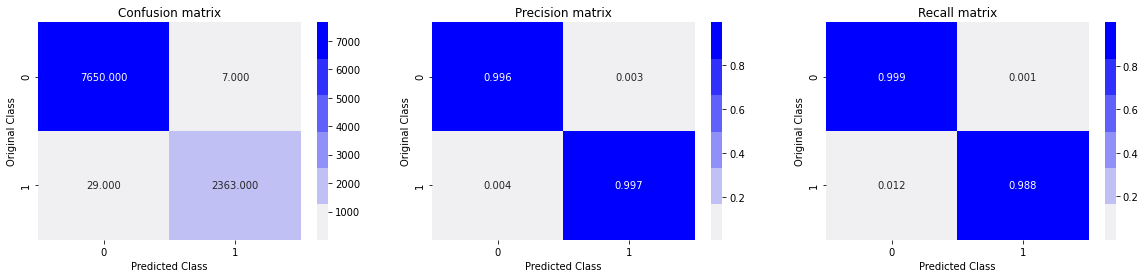

Test Data Results
Accuracy 98.69%
Confusion matrix, Pecision, recall


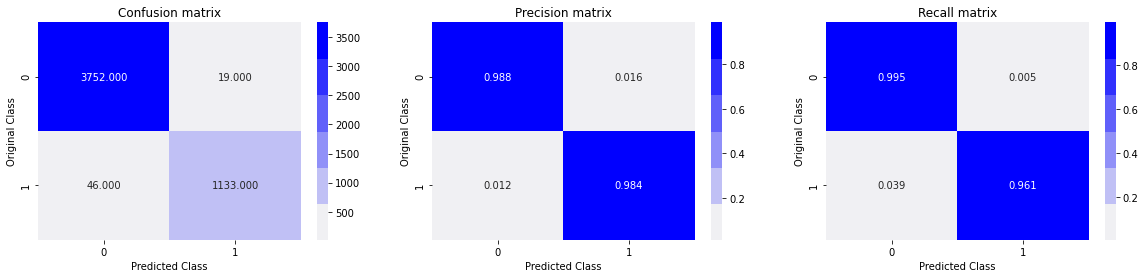

In [ ]:
random_forest_classifier(X_train,y_train,X_test,y_test)


### XGBOOST

In [ ]:
from xgboost.sklearn import XGBClassifier

In [ ]:
def xgbclassifier(train,y_train,test,y_test):
  standard_scallar = StandardScaler()
  train = standard_scallar.fit_transform(train)
  test = standard_scallar.transform(test)
  # Hyper parameter
  # min_child_weight = [6,8,10,12]
  # max_depth = [5, 8,13, 15]
  gamma = [i/10.0 for i in range(0,5)]
  # subsample = [i/10.0 for i in range(6,10)]
  # colsample_bytree  = [i/10.0 for i in range(6,10)]
  param_grid = dict(gamma=gamma)
  # class8ifier
  clf = XGBClassifier(objective= 'binary:logistic',max_depth=13,
                      min_child_weight=6,gama=0.2)
  cv = StratifiedKFold(n_splits=5,random_state=42,shuffle=True)
  search_cv = grid_search(clf,train_data=train,y_train=y_train,cv=cv,params=param_grid)
  best_params = search_cv.best_params_
  print('='*50)
  print('Best Paam')
  print(best_params)
  # min_child_weight = best_params['min_child_weight']
  # max_depth = best_params['max_depth']
  
  gamma = best_params['gamma']
  # min_samples_split = best_params['min_samples_split']
  # min_samples_leaf = best_params['min_samples_leaf']

  # FInal CLF
  clf = XGBClassifier(objective= 'binary:logistic', max_depth=13,
                      min_child_weight=6,gamma=gamma)
  clf.fit(train,y_train)
  # tRAING pREDICTION
  print('Training Data Results')
  predicted = clf.predict(train)
  print("Accuracy {0:.2f}%".format(100*accuracy_score(predicted, y_train)))
  print('Confusion matrix, Pecision, recall')
  plot_confusion_matrix(y_train, predicted)
  # Test Data results
  print('Test Data Results')
  predicted = clf.predict(test)
  print("Accuracy {0:.2f}%".format(100*accuracy_score(predicted, y_test)))
  print('Confusion matrix, Pecision, recall')
  plot_confusion_matrix(y_test, predicted)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   34.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   34.0s finished


Best Paam
{'gamma': 0.2}
Training Data Results
Accuracy 98.92%
Confusion matrix, Pecision, recall


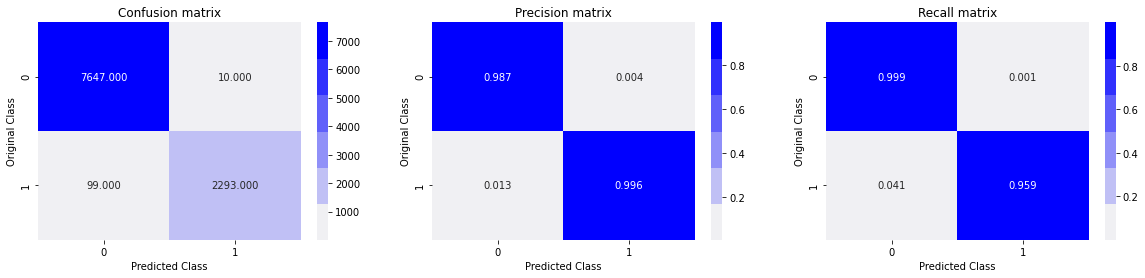

Test Data Results
Accuracy 98.16%
Confusion matrix, Pecision, recall


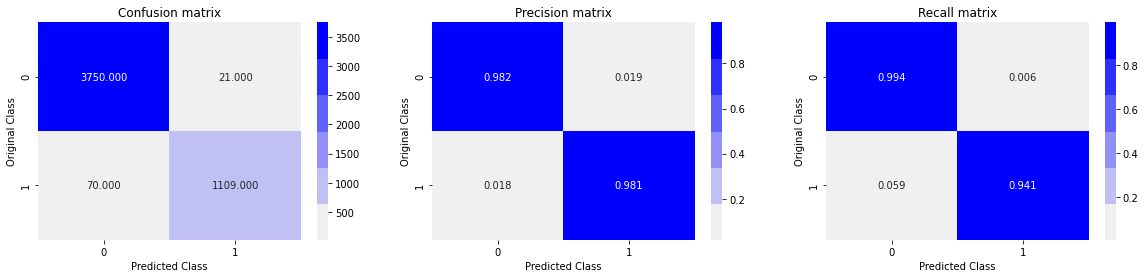

In [ ]:
xgbclassifier(X_train,y_train,X_test,y_test)


## Deep Learning Model Using Tensorflow 2

In [ ]:
# Use the newest version of TensorFlow 2.0
%tensorflow_version 2.x 

In [ ]:
# If you wish to use Tensorflow 1.X run the following line and then restart runtime
# %tensorflow_version 1.x 
# You'll need to change your import statements from tensorflow.keras to keras
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()

model.add(Dense(9, kernel_initializer = "uniform", activation = "relu", input_dim=20))
model.add(Dense(1, kernel_initializer = "uniform", activation = "sigmoid"))

model.compile(optimizer= "adam",loss = "binary_crossentropy",metrics = ["accuracy"])

In [ ]:
# Display Model Summary and Show Parameters
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 9)                 189       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 10        
Total params: 199
Trainable params: 199
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Start Training Our Classifier 
batch_size = 10
epochs = 25

history = model.fit(X_train,
                    y_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose = 1,
                    validation_data = (X_test, y_test))

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/25
1005/1005 [==============================] - 2s 2ms/step - loss: 0.2211 - accuracy: 0.9239 - val_loss: 0.2121 - val_accuracy: 0.9285
Epoch 2/25
1005/1005 [==============================] - 2s 2ms/step - loss: 0.2194 - accuracy: 0.9263 - val_loss: 0.2047 - val_accuracy: 0.9293
Epoch 3/25
1005/1005 [==============================] - 2s 2ms/step - loss: 0.2224 - accuracy: 0.9228 - val_loss: 0.2040 - val_accuracy: 0.9285
Epoch 4/25
1005/1005 [==============================] - 2s 2ms/step - loss: 0.2185 - accuracy: 0.9266 - val_loss: 0.2044 - val_accuracy: 0.9319
Epoch 5/25
1005/1005 [==============================] - 2s 2ms/step - loss: 0.2183 - accuracy: 0.9225 - val_loss: 0.2011 - val_accuracy: 0.9311
Epoch 6/25
1005/1005 [==============================] - 2s 2ms/step - loss: 0.2188 - accuracy: 0.9259 - val_loss: 0.2035 - val_accuracy: 0.9283
Epoch 7/25
1005/1005 [==============================] - 2s 2ms/step - loss: 0.2194 - accuracy: 0.9251 - val_loss: 0.2196 - val_accuracy:

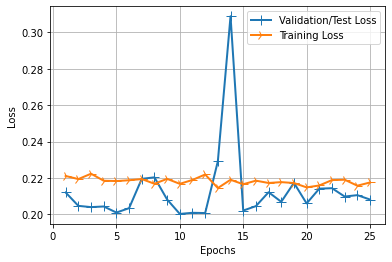

In [ ]:
# Plotting our loss charts
import matplotlib.pyplot as plt

history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

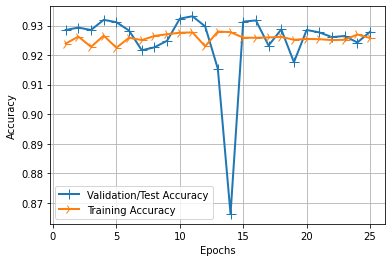

In [ ]:
# Plotting our accuracy charts
import matplotlib.pyplot as plt

history_dict = history.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label='Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

## Let's a Deeper Model

In [ ]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout

model2 = Sequential()

# Hidden Layer 1
model2.add(Dense(270, activation='relu', input_dim=20, kernel_regularizer=l2(0.01)))
model2.add(Dropout(0.3, noise_shape=None, seed=None))

# Hidden Layer 1
model2.add(Dense(180, activation='relu', input_dim=20, kernel_regularizer=l2(0.01)))
model2.add(Dropout(0.3, noise_shape=None, seed=None))

# Hidden Layer 2
model2.add(Dense(90, activation = 'relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3, noise_shape=None, seed=None))

model2.add(Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 270)               5670      
_________________________________________________________________
dropout (Dropout)            (None, 270)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 180)               48780     
_________________________________________________________________
dropout_1 (Dropout)          (None, 180)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 90)                16290     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 91        
Total params: 70,831
Trainable params: 70,831
Non-trainable params: 0
__________________________________________________

In [ ]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
batch_size = 10
epochs = 25

history = model2.fit(X_train,
                    y_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose = 1,
                    validation_data = (X_test, y_test))

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/25
1005/1005 [==============================] - 4s 3ms/step - loss: 3.2343 - accuracy: 0.6859 - val_loss: 1.3602 - val_accuracy: 0.7444
Epoch 2/25
1005/1005 [==============================] - 3s 3ms/step - loss: 1.2243 - accuracy: 0.7776 - val_loss: 0.7876 - val_accuracy: 0.8200
Epoch 3/25
1005/1005 [==============================] - 3s 3ms/step - loss: 0.7610 - accuracy: 0.7964 - val_loss: 0.5438 - val_accuracy: 0.8366
Epoch 4/25
1005/1005 [==============================] - 3s 3ms/step - loss: 0.5270 - accuracy: 0.8264 - val_loss: 0.4230 - val_accuracy: 0.8525
Epoch 5/25
1005/1005 [==============================] - 3s 3ms/step - loss: 0.4440 - accuracy: 0.8262 - val_loss: 0.4033 - val_accuracy: 0.8426
Epoch 6/25
1005/1005 [==============================] - 3s 3ms/step - loss: 0.3968 - accuracy: 0.8406 - val_loss: 0.4103 - val_accuracy: 0.8384
Epoch 7/25
1005/1005 [==============================] - 3s 3ms/step - loss: 0.3889 - accuracy: 0.8469 - val_loss: 0.3985 - val_accuracy:

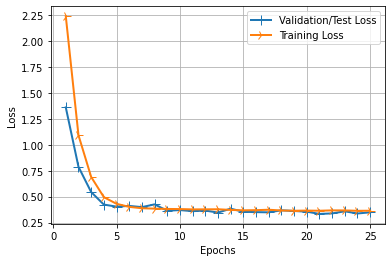

In [ ]:
# Plotting our loss charts
import matplotlib.pyplot as plt

history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

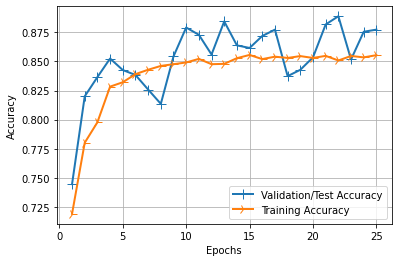

In [ ]:
# Plotting our accuracy charts
import matplotlib.pyplot as plt

history_dict = history.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label='Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

## Model Comparision

In [4]:
models = ['Logistic Regression','K-Nearset Neighbours',
          'Support Vector Machine','Random Forest', 'XGBoost','Deep Learning Model']
Training_Accuracy = ['82.65%','100.00%','99.07%','99.64%','98.92%','87.89%']
Test_Accuracy = ['82.59%','96.12%','97.64%','98.69%','98.16%','90.54']
compare_dict = {'Models':models,'Training Accuracy':Training_Accuracy,'Test Accuracy':Test_Accuracy}
compare_dictdf = pd.DataFrame.from_dict(compare_dict)
compare_dictdf

,Models,Training Accuracy,Test Accuracy
0,Logistic Regression,82.65%,82.59%
1,K-Nearset Neighbours,100.00%,96.12%
2,Support Vector Machine,99.07%,97.64%
3,Random Forest,99.64%,98.69%
4,XGBoost,98.92%,98.16%
5,Deep Learning Model,87.89%,90.54


# Conclusion:
> - XGBoost Model is performing Best as there is very less difference between train and test accuracy
> - Logistic Regression is the base model which has accuracy less for training and test data set.